In [73]:
import os
import shutil
import random
import logging
import time
import json
from tempfile import TemporaryDirectory
from PIL import Image
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import RandAugment

import torchvision
from torchvision import models, transforms

import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageFilter
import random

# Configurations
cudnn.benchmark = True
plt.ion()  # interactive mode

# Logging Configuration
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
generator = torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

%set_env CUBLAS_WORKSPACE_CONFIG=:4096:8

Random Seed:  999
env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [74]:
# Base data path
BASE_DATA_DIR = "data"
RESIZED_DATA_DIR = "resized_data"

# Directories for real and fake images
REAL_DIR = os.path.join(BASE_DATA_DIR, "wiki")  # Path to real images
FAKE_DIRS = ["inpainting", "insight", "text2img"]  # Directories for fake images

TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
assert(TRAIN_SPLIT + VAL_SPLIT + TEST_SPLIT == 1)

# Number of desired images
num_real_images = 30000
num_fake_images_per_folder = 30000

def create_directories():
    """Creates necessary directories for train and validation sets, removing old data first."""
    for category in ['train', 'val', 'test']:
        for subdir in ['real', 'fake']:
            dir_path = os.path.join(RESIZED_DATA_DIR, category, subdir)

            # Remove all existing files to prevent dataset accumulation
            if os.path.exists(dir_path):
                shutil.rmtree(dir_path)

            os.makedirs(dir_path, exist_ok=False)

def get_image_paths(directory):
    """Returns a list of image file paths within a directory structure."""
    image_paths = []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            image_paths.extend(
                [
                    os.path.join(subdir_path, file)
                    for file in os.listdir(subdir_path)
                    if os.path.isfile(os.path.join(subdir_path, file))
                ]
            )
    return image_paths

def split_and_copy_images(image_paths, category):
    """Splits images into training, validation and test sets and copies them accordingly."""
    train, val, test = random_split(image_paths, [TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT], generator)
    def save_images(image_paths, destination):
        for image_path in image_paths:
            # Turns out images can have the same name, so we add a timestamp to the filename
            target_path = os.path.join(RESIZED_DATA_DIR, destination, category, str(time.time()) + os.path.basename(image_path))
            shutil.copy(image_path, target_path)
    save_images(train, 'train')
    save_images(val, 'val')
    save_images(test, 'test')

# Function to split images into 'train' and 'val'
def organize_data():
    # Create destination directories
    create_directories()

    # Handle real images
    real_images = get_image_paths(REAL_DIR)
    # Random sampling of real images
    sampled_real_images = random.sample(real_images, num_real_images)
    logging.info(f"Sampled {len(sampled_real_images)} real images.")

    # Split into train, val, test and copy to destination
    split_and_copy_images(sampled_real_images, 'real')

    # Handle fake images and random sampling
    sampled_fake_images = {
        fake_dir: random.sample(
            get_image_paths(os.path.join(BASE_DATA_DIR, fake_dir)),
            num_fake_images_per_folder,
        )
        for fake_dir in FAKE_DIRS
    }

    total_sampled_fake_images = sum(len(imgs) for imgs in sampled_fake_images.values())
    logging.info(f"Sampled {total_sampled_fake_images} fake images.")

    # Split into train, val, test and copy to destination
    for dir, sampled_images in sampled_fake_images.items():
        split_and_copy_images(sampled_images, 'fake')

    logging.info("Data organized successfully.")

organize_data()

2025-04-01 21:32:13,027 - INFO - Sampled 30000 real images.
2025-04-01 21:32:14,468 - INFO - Sampled 90000 fake images.
2025-04-01 21:32:17,550 - INFO - Data organized successfully.


In [75]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [76]:
# Data augmentation and normalization for training
# Just normalization for validation

# Also accessible with models.ResNet18_Weights.transforms()
resnet_basic_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)
resnet_augmentation_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally
        transforms.RandomRotation(degrees=15),  # Rotate up to 15 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color changes
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)
# resnet_augmentation_transform_v2 = transforms.Compose( # similar to efficient net's augmentation (for comparison)
#     [
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally
#         RandAugment(),  # applies some transforms (randomly chosen)
#         transforms.ToTensor(),
#         transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
#     ]
# )

efficient_net_basic_transform = transforms.Compose([
    transforms.Resize(384),
    transforms.CenterCrop(384),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
efficient_net_augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(384),
    transforms.RandomHorizontalFlip(p=0.5),
    RandAugment(),  # applies some transforms (randomly chosen)
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

vit_basic_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
vit_augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

models_tranforms_dict = {
    "resnet": {
        "train": resnet_augmentation_transform,
        "val": resnet_basic_transform,
        "test": resnet_basic_transform,
    },
    "efficient_net": {
        "train": efficient_net_augmentation_transform,
        "val": efficient_net_basic_transform,
        "test": efficient_net_basic_transform,
    },
    "vit": {
        "train": vit_augmentation_transform,
        "val": vit_basic_transform,
        "test": vit_basic_transform,
    },
}

In [77]:
class SimCLRGaussianBlur:
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[0.1, 2.0]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

class TwoCropsTransform:
    """Take two random crops of one image as the query and key"""
    def __init__(self, base_transform):
        self.base_transform = base_transform
    
    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

simclr_transform = transforms.Compose([
    # Random resized crop
    transforms.RandomResizedCrop(size=224, scale=(0.2, 1.0)),

    # Color jittering
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),

    # Random grayscale
    transforms.RandomGrayscale(p=0.2),

    transforms.RandomApply([
        SimCLRGaussianBlur(sigma=(0.1, 2.0)),
    ], p=0.5),

    # Random horizontal flip
    transforms.RandomHorizontalFlip(),
    
    # Convert to tensor
    transforms.ToTensor(),
    
    # Normalize (using ImageNet stats)
    transforms.Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD,
    )
])

In [78]:
# Now pointing to the resized data folder
data_dir = RESIZED_DATA_DIR
SPLITS = ["train", "val", "test"]

def get_dataset(transform):
    return {
        x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), transform[x])
        for x in SPLITS
        if x in transform
    }

datasets = {
    "no_augmentation": {
        model: get_dataset(transforms)
        for model, transforms in models_tranforms_dict.items()
    },
    "augmentation": {
        model: get_dataset(transforms)
        for model, transforms in models_tranforms_dict.items()
    },
}
batch_sizes = { # CUDA out of memory error if batch size is too large
    "resnet": 32,
    "efficient_net": 16,
    "vit": 32,
}
dataloaders = {
    has_augmentation: {
        model: {
            x: DataLoader(dataset[x], batch_size=batch_sizes[model], shuffle=(x == "train"), num_workers=4)
            for x in SPLITS
        }
        for model, dataset in model_datasets.items()
    }
    for has_augmentation, model_datasets in datasets.items()
}
default_dataset = datasets["augmentation"]["resnet"]
default_dataloader = dataloaders["augmentation"]["resnet"]

# Get the size of each split (same for both without and with augmentation)
dataset_sizes = {x: len(default_dataset[x]) for x in SPLITS}
# Get the class names (same for both without and with augmentation)
class_names = default_dataset["train"].classes

In [79]:
dataset_sizes

{'train': 84000, 'val': 18000, 'test': 18000}

In [80]:
# PRETRAIN_BATCH_SIZE = 256
PRETRAIN_BATCH_SIZE = 64
DESIRED_PRETRAIN_BATCH_SIZE = 256
NUM_WORKERS = 16
LR_STEPS = [60, 80]

In [81]:
pretrain_dataset = get_dataset({"train": TwoCropsTransform(simclr_transform)})
pretrain_dataloader = DataLoader(
    pretrain_dataset["train"],
    batch_size=PRETRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [ ]:
class MoCo(nn.Module):
    """
    Momentum Contrastive Learning (MoCo) implementation
    
    Key components:
    1. Query encoder (online network)
    2. Key encoder (momentum network)
    3. Memory bank for negative samples
    4. Contrastive loss computation
    """
    def __init__(self, feature_dim=128, queue_size=65536, momentum=0.999, temperature=0.07):
        """
        Initialize MoCo model
        
        Args:
            feature_dim (int): Dimensionality of feature representation
            queue_size (int): Size of the memory bank for negative samples
            momentum (float): Momentum for updating key encoder
        """
        super(MoCo, self).__init__()
        self.momentum = momentum
        self.temperature = temperature

        # Change both models if desired (e.g. resnet18, resnet50)
        # To change to another architecture, would have to change more things

        # Query encoder (online network)
        self.encoder_q = models.resnet18(weights=None, num_classes=feature_dim)

        # Key encoder (momentum network)
        self.encoder_k = models.resnet18(weights=None, num_classes=feature_dim)

        # Freeze momentum encoder's parameters
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False
        
        # Create memory bank (queue)
        self.register_buffer("queue", torch.randn(feature_dim, queue_size))
        self.queue = F.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))
        
    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """
        Momentum update of the key encoder
        """
        # parameters of the key encoder will evolve more smoothly than the query encoder
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.momentum + param_q.data * (1.0 - self.momentum)
    
    def _dequeue_and_enqueue(self, keys):
        """
        Dequeue the oldest batch and enqueue the current batch
        
        Args:
            keys (torch.Tensor): Batch of key representations
        """
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)

        # TODO: DOUBTS HERE
        
        # Replace the keys at ptr (and ptr+1, etc.)
        if ptr + batch_size > self.queue.size(1):
            # Wrap around if we've reached the end of the queue
            self.queue[:, ptr:] = keys[:, :self.queue.size(1) - ptr].T
            self.queue[:, :batch_size - (self.queue.size(1) - ptr)] = keys[:, self.queue.size(1) - ptr:].T
        else:
            self.queue[:, ptr:ptr + batch_size] = keys.T
        
        # Move pointer
        ptr = (ptr + batch_size) % self.queue.size(1)
        self.queue_ptr[0] = ptr
    
    def forward(self, x_q, x_k):
        """
        Forward pass for contrastive learning
        
        Args:
            x_q (torch.Tensor): Query view of the image
            x_k (torch.Tensor): Key view of the image
        
        Returns:
            Contrastive loss
        """
        batch_size = x_q.shape[0]

        # Compute query features
        q = self.encoder_q(x_q)
        q = F.normalize(q, dim=1)   # Normalize last layer result by L2 norm: paper page 4 technical details
        
        # Compute key features (detached from gradient)
        with torch.no_grad():
            # Momentum update for key encoder
            # This would be inconsistent with MoCo: why? we're updating the momentum encoder parameters 4 times "per mini-batch" (of 256)
            # self._momentum_update_key_encoder()
            
            # Shuffle the key images
            # again, here we are just shuffling 64 instances and not 256 (works anyway)
            shuffle_idx = torch.randperm(batch_size).to(x_k.device)
            k_shuffled = x_k[shuffle_idx]
            
            # Compute key features
            k = self.encoder_k(k_shuffled)
            k = F.normalize(k, dim=1)   # Normalize last layer result by L2 norm
        
            unshuffle_idx = torch.argsort(shuffle_idx)
            k = k[unshuffle_idx]

        # Compute positive logits
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        
        # Compute negative logits
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])
        
        # Contrastive logits
        logits = torch.cat([l_pos, l_neg], dim=1)
        
        # Temperature-scaled logits
        logits /= self.temperature
        
        # Labels for contrastive loss (first column is positive)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(logits.device)
        
        # Compute InfoNCE loss
        # This could be done outside, but to abstract we leave it here
        loss = F.cross_entropy(logits, labels)
        
        # Update memory bank
        self._dequeue_and_enqueue(k)
        
        return loss

# Example usage
def train_moco(model: MoCo, data_loader, optimizer, device):
    """
    Training loop for MoCo
    
    Args:
        model (MoCo): MoCo model
        data_loader (DataLoader): Training data loader
        optimizer (Optimizer): Optimizer
        device (torch.device): Computing device
    """
    model.train()
    total_loss = 0

    accumulation_steps = DESIRED_PRETRAIN_BATCH_SIZE // PRETRAIN_BATCH_SIZE  # Gradient accumulation step
    for i, (ims, y) in enumerate(data_loader):
        # Assume batch contains two augmented views of the same image
        x_q, x_k = ims[0].to(device), ims[1].to(device)

        if i % accumulation_steps == 0:
            # avoid updating the momentum encoder too often
            model._momentum_update_key_encoder()    # do it just once per accumulation step
            # still not exactly the same as the code from the paper
            # since they use drop_last and here we would be updating it once more even if the last batch cannot make up 256

        # Compute contrastive loss
        loss = model(x_q, x_k)

        loss = loss / accumulation_steps   # Normalize loss by accumulation steps because of gradient accumulation

        # Backpropagate
        loss.backward()

        # Gradient accumulation
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        total_loss += loss.item()  # Accumulate loss for the batch size

    optimizer.zero_grad()   # Facebook implementation has drop_last=True
    
    return total_loss / len(data_loader)  # Average loss per sample

In [84]:
def epoch_to_learning_rate(epoch, base_lr, steps):
    """Gets the new learning rate based on epoch and predefined steps"""
    lr = base_lr
    for step in steps:
        if epoch >= step:
            lr *= 0.1
    return lr

def change_lr(optimizer, epoch, base_lr, steps):
    """Sets the learning rate of the optimizer based on epoch and predefined steps"""
    lr = epoch_to_learning_rate(epoch, base_lr, steps)
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    return lr

# Full training script
def main(model_save_path):
    # Hyperparameters
    feature_dim = 128
    queue_size = 65536
    momentum = 0.999
    learning_rate = 0.03
    num_epochs = 100    # 200 (paper has 200?, code has 100)
    batch_size = 256
    temperature = 0.07

    moco_model = MoCo(feature_dim, queue_size, momentum).to(device)

    # Optimizer
    optimizer = torch.optim.SGD(moco_model.parameters(), 
                                lr=learning_rate, 
                                momentum=0.9, 
                                weight_decay=1e-4)

    # Initialize MoCo model
    moco_model = MoCo(feature_dim, queue_size, momentum, temperature).to(device)
    
    # Optimizer
    optimizer = torch.optim.SGD(
        moco_model.parameters(),
        lr=learning_rate,
        momentum=0.9,
        weight_decay=1e-4,
    )

    losses = []
    best_avg_loss = float('inf')
    # Training loop
    for epoch in range(num_epochs):
        avg_loss = train_moco(moco_model, pretrain_dataloader, optimizer, device)
        change_lr(optimizer, epoch, learning_rate, LR_STEPS)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            torch.save(moco_model.state_dict(), model_save_path)
        losses.append(avg_loss)

    print(f"Best average loss: {best_avg_loss:.4f}")

    # Plotting the loss
    plt.plot(range(1, num_epochs + 1), losses, 'b-', label='Training Loss')  # Blue line with explicit x-axis
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('MoCoV2 Training Loss')
    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid for better readability
    plt.legend()  # Add legend
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.savefig("moco_training_loss.png", dpi=300)  # Higher DPI for better quality
    plt.close()

# 1 epoch, ~6m30s

In [85]:
main('moco_model_resnet18.pth')

Epoch [1/100], Loss: 2.1380
Epoch [2/100], Loss: 1.9936
Epoch [3/100], Loss: 1.8394
Epoch [4/100], Loss: 1.7260
Epoch [5/100], Loss: 1.6223
Epoch [6/100], Loss: 1.5429
Epoch [7/100], Loss: 1.4702
Epoch [8/100], Loss: 1.4018
Epoch [9/100], Loss: 1.3386
Epoch [10/100], Loss: 1.2788
Epoch [11/100], Loss: 1.2227
Epoch [12/100], Loss: 1.1686
Epoch [13/100], Loss: 1.1220
Epoch [14/100], Loss: 1.0780
Epoch [15/100], Loss: 1.0410
Epoch [16/100], Loss: 1.0108
Epoch [17/100], Loss: 0.9793
Epoch [18/100], Loss: 0.9534
Epoch [19/100], Loss: 0.9243
Epoch [20/100], Loss: 0.9004
Epoch [21/100], Loss: 0.8836
Epoch [22/100], Loss: 0.8619
Epoch [23/100], Loss: 0.8445
Epoch [24/100], Loss: 0.8245
Epoch [25/100], Loss: 0.8077
Epoch [26/100], Loss: 0.7901
Epoch [27/100], Loss: 0.7785
Epoch [28/100], Loss: 0.7620
Epoch [29/100], Loss: 0.7511
Epoch [30/100], Loss: 0.7372
Epoch [31/100], Loss: 0.7261
Epoch [32/100], Loss: 0.7157
Epoch [33/100], Loss: 0.7050
Epoch [34/100], Loss: 0.6918
Epoch [35/100], Loss: 0

In [13]:
#load model
def load_model(model, path):
    """
    Load the model weights from a specified path.
    
    Args:
        model (nn.Module): The model to load weights into.
        path (str): Path to the model weights file.
    """
    if os.path.isfile(path):
        print(f"Loading model from {path}")
        state_dict = torch.load(path)
        model.load_state_dict(state_dict)
    else:
        print(f"No checkpoint found at {path}")
    return model

In [ ]:
# Load the pre-trained model
pretrained_model_path = "moco_model_resnet18.pth"

In [15]:
# see results of a few images
def show_results(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for ims, _ in dataloader:
            x_q, x_k = ims[0].to(device), ims[1].to(device)
            q = model.encoder_q(x_q)
            k = model.encoder_k(x_k)
            break

    # Visualize the results
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(q.cpu().numpy()[0].transpose(1, 2, 0))
    ax[0].set_title("Query View")
    ax[1].imshow(k.cpu().numpy()[0].transpose(1, 2, 0))
    ax[1].set_title("Key View")
    plt.show()

# show_results(moco_model, pretrain_dataloader, device)

In [93]:
def extract_from_moco(moco_model_path, num_classes, freeze_layers=True):
    """
    Extract features from the MoCo model.
    
    Args:
        model_path (str): Path to the pre-trained MoCo model.
    
    Returns:
        features (torch.Tensor): Extracted features.
    """
    model = models.resnet18(weights=None, num_classes=num_classes)
    model.fc.weight.data.normal_(mean=0.0, std=0.01)    # Maybe this is bad!?
    model.fc.bias.data.zero_()

    state_dict = torch.load(moco_model_path)
    for k in list(state_dict.keys()):   # just get the encoder_q part
        # retain only encoder_q up to before the embedding layer
        if k.startswith("encoder_q") and not k.startswith("encoder_q.fc"):
            # remove prefix (to make it loadable into the other model)
            # module.encoder_q.<layer> turns to <layer>
            state_dict[k[len("encoder_q.") :]] = state_dict[k]

        del state_dict[k]   # delete unused
    
    msg = model.load_state_dict(state_dict, strict=False)
    assert set(msg.missing_keys) == {"fc.weight", "fc.bias"}

    if freeze_layers:
        # freeze all layers but the last fc
        for name, param in model.named_parameters():
            if name not in ["fc.weight", "fc.bias"]:
                param.requires_grad = False
    assert(model.fc.out_features == num_classes)
    return model

In [95]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, verbose=True):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_f1 = 0.0

        # Store loss, accuracy and f1 values
        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], 
                  "train_f1": [], "val_f1": []}

        for epoch in range(num_epochs):
            if verbose:
                print(f"Epoch {epoch + 1}/{num_epochs}")
                print("-" * 10)

            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                all_preds = []
                all_labels = []
                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    # Collect predictions and labels for F1 score
                    all_preds.extend(preds.tolist())
                    all_labels.extend(labels.tolist())

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == "train" and scheduler is not None:
                    if type(scheduler) is lr_scheduler.ReduceLROnPlateau:
                        scheduler.step(epoch_loss)
                    else:
                        scheduler.step()

                # Convert lists to numpy arrays for sklearn
                all_preds = np.array(all_preds)
                all_labels = np.array(all_labels)

                # Calculate F1 score (using weighted average due to class imbalance)
                epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

                # Store metrics in history
                history[f"{phase}_loss"].append(epoch_loss)
                history[f"{phase}_acc"].append(epoch_acc.item())
                history[f"{phase}_f1"].append(epoch_f1)

                if verbose:
                    print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}")

                # deep copy the model (using F1 score as the criterion for best model)
                if phase == "val" and epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose:
                print()

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        if verbose:
            print(f"Best val F1: {best_f1:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, history

In [90]:
def plot_training_history(history, title_label=""):
    if title_label != "":
        title_label = f": {title_label}"
    epochs = range(len(history["train_loss"]))

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.title(f"Training & Validation Loss{title_label}")
    plt.legend()

    # F1 Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_f1"], label="Train F1")
    plt.plot(epochs, history["val_f1"], label="Validation F1")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title(f"Training & Validation F1 Score{title_label}")
    plt.legend()
    plt.show()

In [96]:
moco_resnet_feature_extraction = extract_from_moco(pretrained_model_path, freeze_layers=True, num_classes=2)
moco_resnet_feature_extraction = moco_resnet_feature_extraction.to(device)

optimizer = torch.optim.SGD(moco_resnet_feature_extraction.fc.parameters(), lr=0.001, momentum=0.9, weight_decay=0)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [97]:
moco_resnet_feature_extraction, moco_resnet_feature_extraction_history = train_model(
    moco_resnet_feature_extraction, dataloaders["augmentation"]["resnet"], criterion, optimizer, exp_lr_scheduler, num_epochs=10, verbose=True
)

Epoch 1/10
----------
train Loss: 0.5252 Acc: 0.7501 F1: 0.6500
val Loss: 0.5077 Acc: 0.7503 F1: 0.6741

Epoch 2/10
----------
train Loss: 0.5151 Acc: 0.7497 F1: 0.6626
val Loss: 0.5035 Acc: 0.7503 F1: 0.6868

Epoch 3/10
----------
train Loss: 0.5127 Acc: 0.7505 F1: 0.6665
val Loss: 0.5144 Acc: 0.7527 F1: 0.6612

Epoch 4/10
----------
train Loss: 0.5102 Acc: 0.7509 F1: 0.6697
val Loss: 0.4974 Acc: 0.7512 F1: 0.6912

Epoch 5/10
----------
train Loss: 0.5085 Acc: 0.7507 F1: 0.6716
val Loss: 0.4982 Acc: 0.7528 F1: 0.6781

Epoch 6/10
----------
train Loss: 0.5073 Acc: 0.7509 F1: 0.6732
val Loss: 0.4955 Acc: 0.7551 F1: 0.6845

Epoch 7/10
----------
train Loss: 0.5076 Acc: 0.7507 F1: 0.6730
val Loss: 0.4998 Acc: 0.7545 F1: 0.6725

Epoch 8/10
----------
train Loss: 0.5055 Acc: 0.7518 F1: 0.6743
val Loss: 0.4924 Acc: 0.7558 F1: 0.6885

Epoch 9/10
----------
train Loss: 0.5056 Acc: 0.7513 F1: 0.6732
val Loss: 0.4942 Acc: 0.7558 F1: 0.6806

Epoch 10/10
----------
train Loss: 0.5060 Acc: 0.7502 F

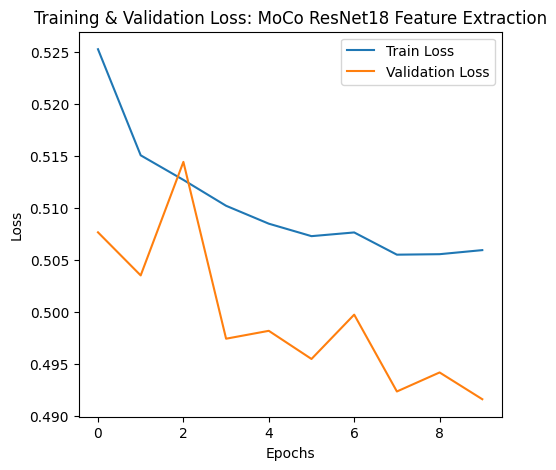

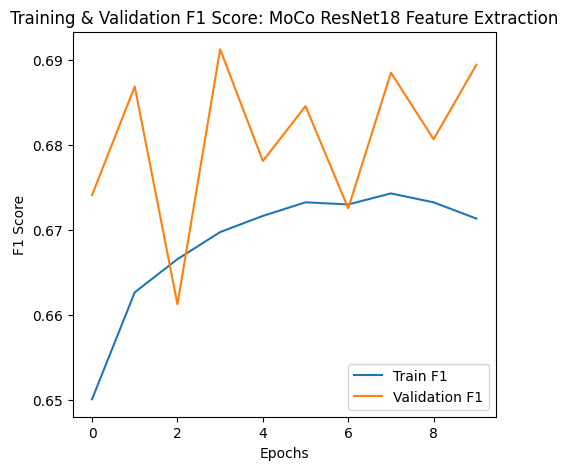

In [98]:
plot_training_history(moco_resnet_feature_extraction_history, title_label="MoCo ResNet18 Feature Extraction")

In [99]:
moco_resnet_feature_extraction_adam = extract_from_moco(pretrained_model_path, freeze_layers=True, num_classes=2)
moco_resnet_feature_extraction_adam = moco_resnet_feature_extraction_adam.to(device)

optimizer = torch.optim.Adam(moco_resnet_feature_extraction_adam.fc.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [100]:
moco_resnet_feature_extraction_adam, moco_resnet_feature_extraction_adam_history = train_model(
    moco_resnet_feature_extraction_adam, dataloaders["augmentation"]["resnet"], criterion, optimizer, None, num_epochs=10, verbose=True
)

Epoch 1/10
----------
train Loss: 0.5367 Acc: 0.7502 F1: 0.6443
val Loss: 0.5185 Acc: 0.7508 F1: 0.6507

Epoch 2/10
----------
train Loss: 0.5195 Acc: 0.7502 F1: 0.6530
val Loss: 0.5145 Acc: 0.7518 F1: 0.6613

Epoch 3/10
----------
train Loss: 0.5159 Acc: 0.7507 F1: 0.6611
val Loss: 0.5103 Acc: 0.7516 F1: 0.6694

Epoch 4/10
----------
train Loss: 0.5136 Acc: 0.7507 F1: 0.6641
val Loss: 0.5077 Acc: 0.7516 F1: 0.6737

Epoch 5/10
----------
train Loss: 0.5111 Acc: 0.7504 F1: 0.6665
val Loss: 0.5041 Acc: 0.7507 F1: 0.6776

Epoch 6/10
----------
train Loss: 0.5109 Acc: 0.7502 F1: 0.6670
val Loss: 0.5052 Acc: 0.7518 F1: 0.6753

Epoch 7/10
----------
train Loss: 0.5105 Acc: 0.7509 F1: 0.6688
val Loss: 0.5021 Acc: 0.7515 F1: 0.6767

Epoch 8/10
----------
train Loss: 0.5101 Acc: 0.7504 F1: 0.6691
val Loss: 0.5019 Acc: 0.7526 F1: 0.6765

Epoch 9/10
----------
train Loss: 0.5092 Acc: 0.7503 F1: 0.6688
val Loss: 0.5013 Acc: 0.7537 F1: 0.6744

Epoch 10/10
----------
train Loss: 0.5085 Acc: 0.7504 F

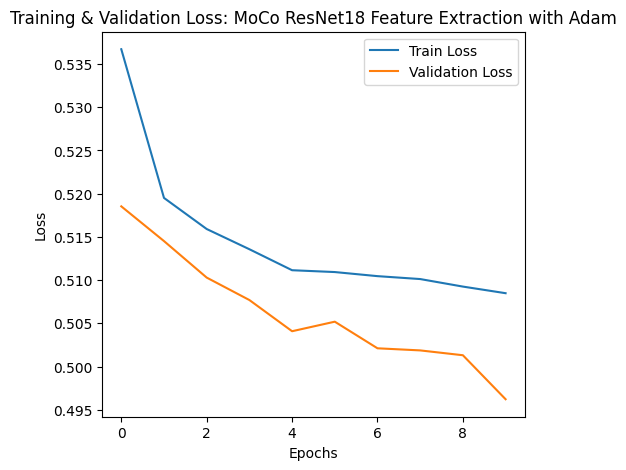

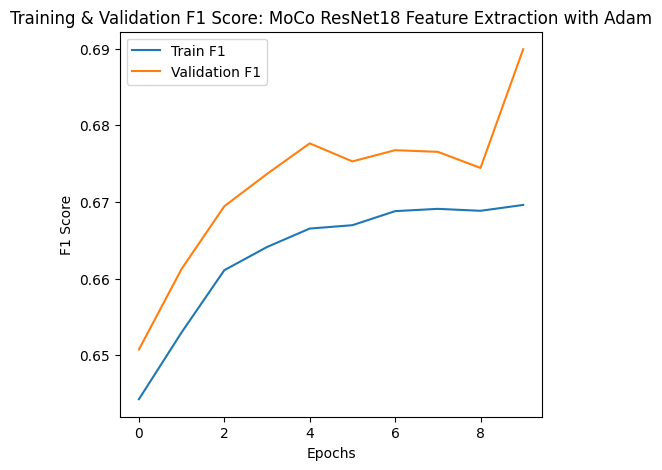

In [101]:
plot_training_history(moco_resnet_feature_extraction_adam_history, title_label="MoCo ResNet18 Feature Extraction with Adam")

In [102]:
moco_resnet_finetuning = extract_from_moco(pretrained_model_path, freeze_layers=False, num_classes=2)
moco_resnet_finetuning = moco_resnet_finetuning.to(device)

optimizer = torch.optim.SGD(moco_resnet_finetuning.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [103]:
moco_resnet_finetuning, moco_resnet_finetuning_history = train_model(
    moco_resnet_finetuning, dataloaders["augmentation"]["resnet"], criterion, optimizer, exp_lr_scheduler, num_epochs=10, verbose=True
)

Epoch 1/10
----------
train Loss: 0.5036 Acc: 0.7535 F1: 0.6713
val Loss: 0.4496 Acc: 0.7698 F1: 0.7215

Epoch 2/10
----------
train Loss: 0.4706 Acc: 0.7692 F1: 0.7235
val Loss: 0.4128 Acc: 0.7968 F1: 0.7683

Epoch 3/10
----------
train Loss: 0.4545 Acc: 0.7767 F1: 0.7432
val Loss: 0.3873 Acc: 0.8101 F1: 0.7835

Epoch 4/10
----------
train Loss: 0.4412 Acc: 0.7854 F1: 0.7575
val Loss: 0.3797 Acc: 0.8221 F1: 0.8052

Epoch 5/10
----------
train Loss: 0.4300 Acc: 0.7913 F1: 0.7690
val Loss: 0.3637 Acc: 0.8279 F1: 0.8135

Epoch 6/10
----------
train Loss: 0.4179 Acc: 0.7996 F1: 0.7815
val Loss: 0.3521 Acc: 0.8341 F1: 0.8254

Epoch 7/10
----------
train Loss: 0.4047 Acc: 0.8064 F1: 0.7916
val Loss: 0.3640 Acc: 0.8273 F1: 0.8023

Epoch 8/10
----------
train Loss: 0.3850 Acc: 0.8207 F1: 0.8073
val Loss: 0.3266 Acc: 0.8499 F1: 0.8373

Epoch 9/10
----------
train Loss: 0.3791 Acc: 0.8233 F1: 0.8112
val Loss: 0.3193 Acc: 0.8534 F1: 0.8406

Epoch 10/10
----------
train Loss: 0.3755 Acc: 0.8247 F

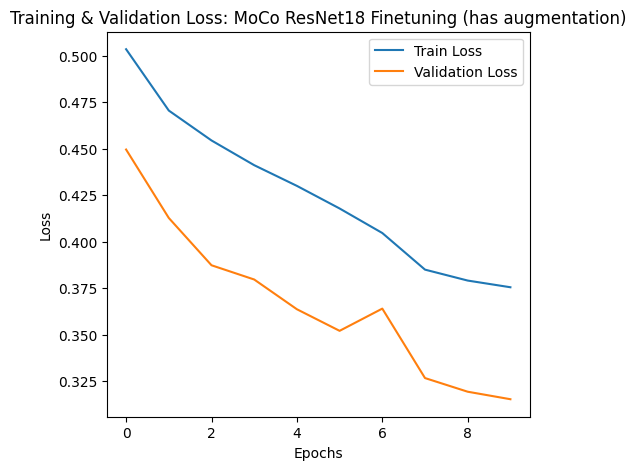

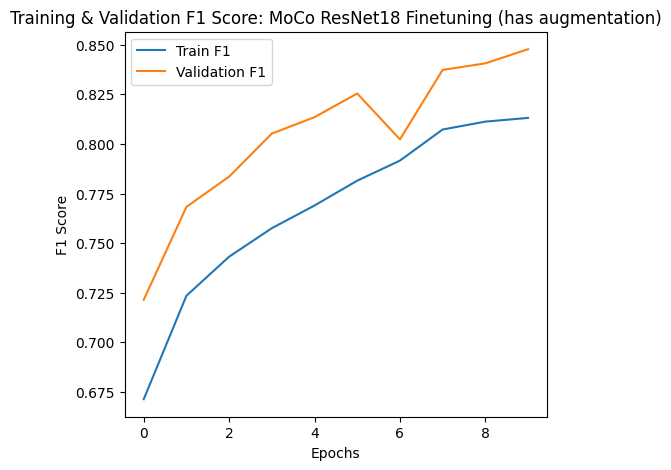

In [111]:
plot_training_history(moco_resnet_finetuning_history, title_label="MoCo ResNet18 Finetuning (has augmentation)")

In [112]:
moco_resnet_finetuning_no_augm = extract_from_moco(pretrained_model_path, freeze_layers=False, num_classes=2)
moco_resnet_finetuning_no_augm = moco_resnet_finetuning_no_augm.to(device)

optimizer = torch.optim.SGD(moco_resnet_finetuning_no_augm.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [113]:
moco_resnet_finetuning_no_augm, moco_resnet_finetuning_no_augm_history = train_model(
    moco_resnet_finetuning_no_augm, dataloaders["no_augmentation"]["resnet"], criterion, optimizer, exp_lr_scheduler, num_epochs=10, verbose=True
)

Epoch 1/10
----------
train Loss: 0.5031 Acc: 0.7543 F1: 0.6742
val Loss: 0.4520 Acc: 0.7727 F1: 0.7148

Epoch 2/10
----------
train Loss: 0.4702 Acc: 0.7680 F1: 0.7234
val Loss: 0.4158 Acc: 0.7912 F1: 0.7491

Epoch 3/10
----------
train Loss: 0.4528 Acc: 0.7780 F1: 0.7458
val Loss: 0.3941 Acc: 0.8118 F1: 0.7919

Epoch 4/10
----------
train Loss: 0.4420 Acc: 0.7823 F1: 0.7547
val Loss: 0.3795 Acc: 0.8198 F1: 0.8108

Epoch 5/10
----------
train Loss: 0.4300 Acc: 0.7895 F1: 0.7671
val Loss: 0.3737 Acc: 0.8199 F1: 0.7919

Epoch 6/10
----------
train Loss: 0.4153 Acc: 0.8008 F1: 0.7834
val Loss: 0.3602 Acc: 0.8309 F1: 0.8110

Epoch 7/10
----------
train Loss: 0.4046 Acc: 0.8071 F1: 0.7920
val Loss: 0.4057 Acc: 0.8063 F1: 0.7623

Epoch 8/10
----------
train Loss: 0.3814 Acc: 0.8213 F1: 0.8088
val Loss: 0.3171 Acc: 0.8589 F1: 0.8514

Epoch 9/10
----------
train Loss: 0.3777 Acc: 0.8243 F1: 0.8124
val Loss: 0.3162 Acc: 0.8549 F1: 0.8426

Epoch 10/10
----------
train Loss: 0.3750 Acc: 0.8253 F

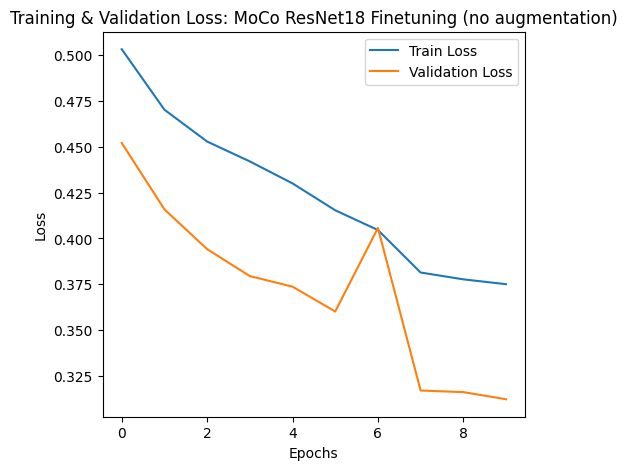

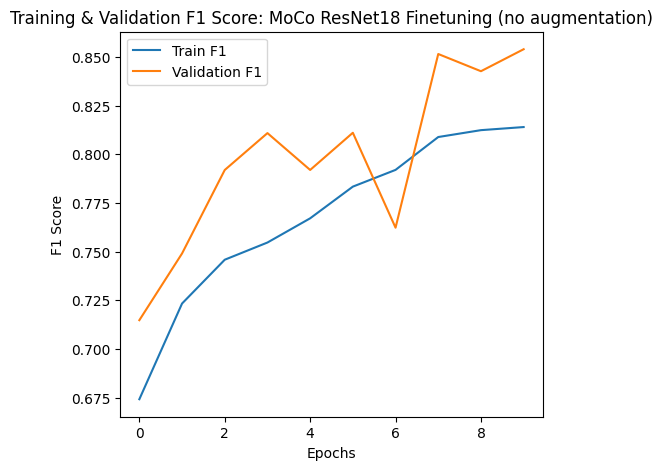

In [114]:
plot_training_history(moco_resnet_finetuning_no_augm_history, title_label="MoCo ResNet18 Finetuning (no augmentation)")

In [33]:
test_model = models.resnet50(weights=None)
test_model.fc = nn.Linear(test_model.fc.in_features, 2)
test_model = test_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(test_model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [34]:
test_model, test_model_history = train_model(
    test_model, dataloaders["augmentation"]["resnet"], criterion, optimizer, exp_lr_scheduler, num_epochs=10, verbose=True
)

Epoch 0/9
----------
Running loss:  53105.470932006836
train Loss: 0.6322 Acc: 0.7301 F1: 0.6522
Running loss:  10375.76773929596
val Loss: 0.5764 Acc: 0.7426 F1: 0.6550

Epoch 1/9
----------
Running loss:  48694.24687004089
train Loss: 0.5797 Acc: 0.7439 F1: 0.6490
Running loss:  9812.940011024475
val Loss: 0.5452 Acc: 0.7486 F1: 0.6507

Epoch 2/9
----------
Running loss:  47602.370955467224
train Loss: 0.5667 Acc: 0.7455 F1: 0.6491
Running loss:  9679.008595466614
val Loss: 0.5377 Acc: 0.7500 F1: 0.6429

Epoch 3/9
----------
Running loss:  46858.6953125
train Loss: 0.5578 Acc: 0.7452 F1: 0.6519
Running loss:  10593.549649953842
val Loss: 0.5885 Acc: 0.7500 F1: 0.6429

Epoch 4/9
----------
Running loss:  46257.65776062012
train Loss: 0.5507 Acc: 0.7457 F1: 0.6504
Running loss:  9442.551723957062
val Loss: 0.5246 Acc: 0.7500 F1: 0.6431

Epoch 5/9
----------
Running loss:  45695.69430208206
train Loss: 0.5440 Acc: 0.7469 F1: 0.6495
Running loss:  9331.913199424744
val Loss: 0.5184 Acc: 

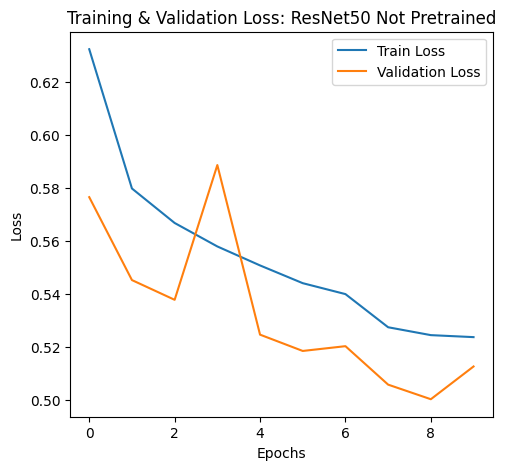

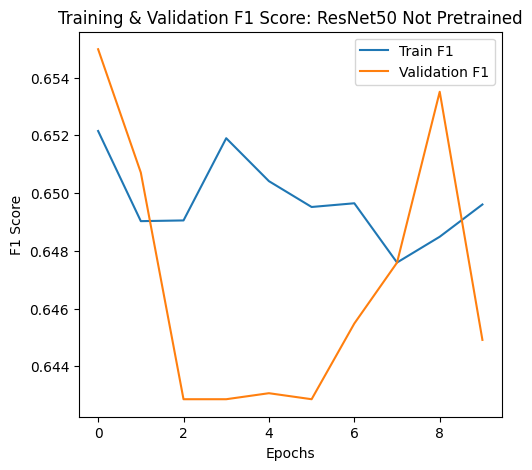

In [ ]:
plot_training_history(test_model_history, title_label="ResNet50 Not Pretrained")

In [105]:
resnet_feature_extraction_random_augm = models.resnet18(weights=None)
for param in resnet_feature_extraction_random_augm.parameters():
    param.requires_grad = False

resnet_feature_extraction_random_augm.fc = nn.Linear(resnet_feature_extraction_random_augm.fc.in_features, 2)
resnet_feature_extraction_random_augm = resnet_feature_extraction_random_augm.to(device)

optimizer = torch.optim.SGD(resnet_feature_extraction_random_augm.fc.parameters(), lr=0.001, momentum=0.9, weight_decay=0)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [106]:
resnet_feature_extraction_random_augm, resnet_feature_extraction_random_augm_history = train_model(
    resnet_feature_extraction_random_augm, dataloaders["augmentation"]["resnet"], criterion, optimizer, exp_lr_scheduler, num_epochs=10, verbose=True
)

Epoch 1/10
----------
train Loss: 0.5716 Acc: 0.7476 F1: 0.6442
val Loss: 0.5629 Acc: 0.7500 F1: 0.6429

Epoch 2/10
----------
train Loss: 0.5669 Acc: 0.7475 F1: 0.6452
val Loss: 0.5524 Acc: 0.7494 F1: 0.6454

Epoch 3/10
----------
train Loss: 0.5651 Acc: 0.7474 F1: 0.6468
val Loss: 0.5512 Acc: 0.7501 F1: 0.6433

Epoch 4/10
----------
train Loss: 0.5656 Acc: 0.7463 F1: 0.6476
val Loss: 0.5961 Acc: 0.7501 F1: 0.6430

Epoch 5/10
----------
train Loss: 0.5630 Acc: 0.7472 F1: 0.6477
val Loss: 0.5485 Acc: 0.7502 F1: 0.6435

Epoch 6/10
----------
train Loss: 0.5661 Acc: 0.7458 F1: 0.6486
val Loss: 0.5637 Acc: 0.7501 F1: 0.6431

Epoch 7/10
----------
train Loss: 0.5639 Acc: 0.7469 F1: 0.6486
val Loss: 0.5503 Acc: 0.7486 F1: 0.6463

Epoch 8/10
----------
train Loss: 0.5535 Acc: 0.7494 F1: 0.6448
val Loss: 0.5467 Acc: 0.7499 F1: 0.6449

Epoch 9/10
----------
train Loss: 0.5524 Acc: 0.7496 F1: 0.6450
val Loss: 0.5483 Acc: 0.7500 F1: 0.6433

Epoch 10/10
----------
train Loss: 0.5533 Acc: 0.7493 F

In [107]:
resnet_feature_extraction_random_no_augm = models.resnet18(weights=None)
for param in resnet_feature_extraction_random_no_augm.parameters():
    param.requires_grad = False

resnet_feature_extraction_random_no_augm.fc = nn.Linear(resnet_feature_extraction_random_no_augm.fc.in_features, 2)
resnet_feature_extraction_random_no_augm = resnet_feature_extraction_random_no_augm.to(device)

optimizer = torch.optim.SGD(resnet_feature_extraction_random_no_augm.fc.parameters(), lr=0.001, momentum=0.9, weight_decay=0)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [108]:
resnet_feature_extraction_random_no_augm, resnet_feature_extraction_random_no_augm_history = train_model(
    resnet_feature_extraction_random_no_augm, dataloaders["no_augmentation"]["resnet"], criterion, optimizer, exp_lr_scheduler, num_epochs=10, verbose=True
)

Epoch 1/10
----------
train Loss: 0.5694 Acc: 0.7472 F1: 0.6453
val Loss: 0.6196 Acc: 0.7500 F1: 0.6429

Epoch 2/10
----------
train Loss: 0.5691 Acc: 0.7469 F1: 0.6487
val Loss: 0.5493 Acc: 0.7501 F1: 0.6442

Epoch 3/10
----------
train Loss: 0.5653 Acc: 0.7471 F1: 0.6478
val Loss: 0.5599 Acc: 0.7499 F1: 0.6428

Epoch 4/10
----------
train Loss: 0.5653 Acc: 0.7464 F1: 0.6467
val Loss: 0.5478 Acc: 0.7499 F1: 0.6430

Epoch 5/10
----------
train Loss: 0.5650 Acc: 0.7466 F1: 0.6481
val Loss: 0.5471 Acc: 0.7498 F1: 0.6448

Epoch 6/10
----------
train Loss: 0.5643 Acc: 0.7465 F1: 0.6488
val Loss: 0.5510 Acc: 0.7477 F1: 0.6529

Epoch 7/10
----------
train Loss: 0.5626 Acc: 0.7466 F1: 0.6477
val Loss: 0.5480 Acc: 0.7489 F1: 0.6468

Epoch 8/10
----------
train Loss: 0.5544 Acc: 0.7495 F1: 0.6451
val Loss: 0.5468 Acc: 0.7498 F1: 0.6430

Epoch 9/10
----------
train Loss: 0.5540 Acc: 0.7496 F1: 0.6448
val Loss: 0.5519 Acc: 0.7500 F1: 0.6430

Epoch 10/10
----------
train Loss: 0.5529 Acc: 0.7497 F

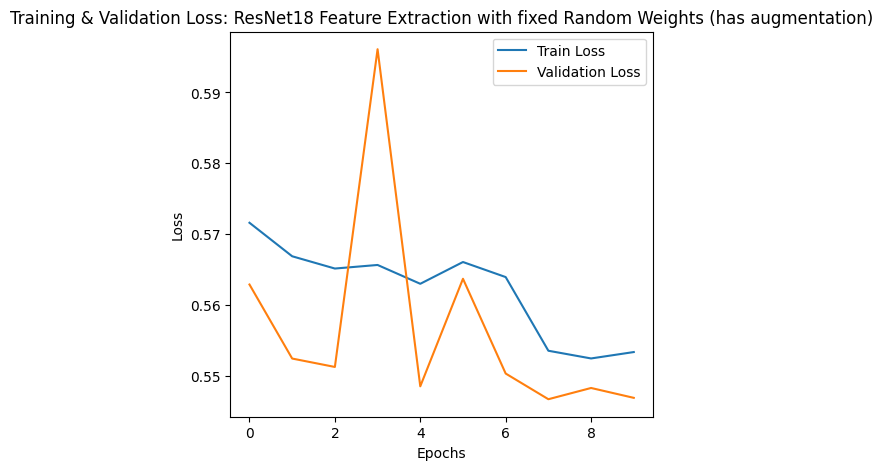

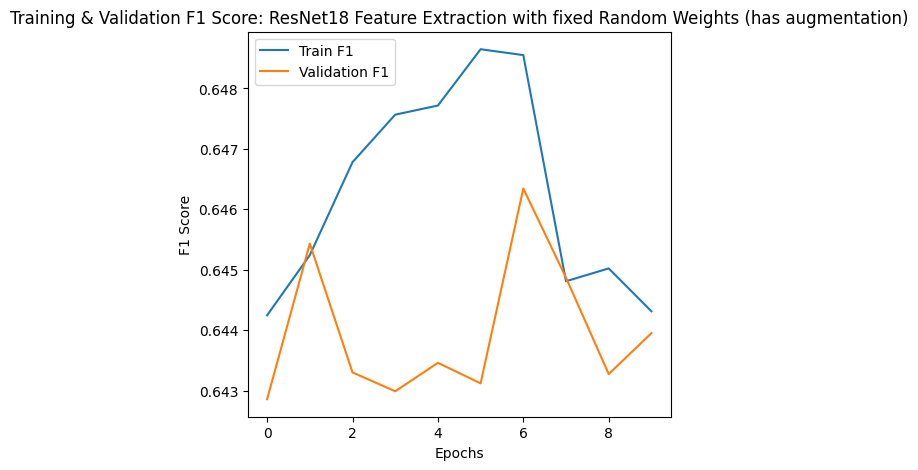

In [109]:
plot_training_history(
    resnet_feature_extraction_random_augm_history,
    title_label="ResNet18 Feature Extraction with fixed Random Weights (has augmentation)"
)

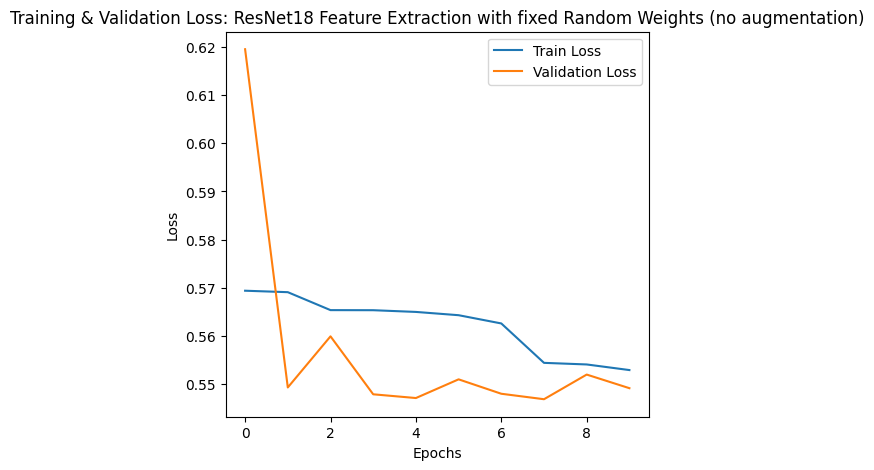

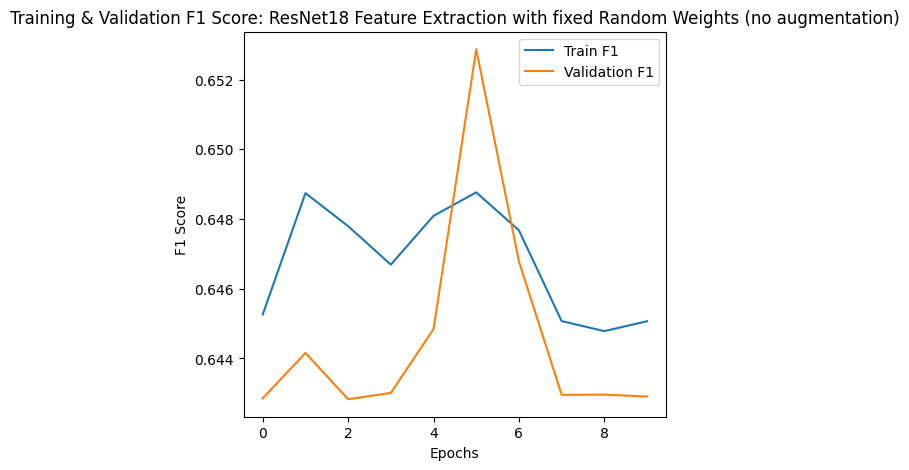

In [110]:
plot_training_history(
    resnet_feature_extraction_random_no_augm_history,
    title_label="ResNet18 Feature Extraction with fixed Random Weights (no augmentation)"
)